# Exploring the Australian Energy Market: A 3-Part Series

Welcome to this 3-part series where we dive into the fascinating world of the Australian energy market. Each day, we will focus on a different aspect of the market, conducting a full data analysis to uncover insights. Here's what you can expect:

- **Day 1: Mapping Renewable Generation and Market Basics**  
    We'll begin by mapping renewable energy generation across Australia, exploring the distribution of power stations, their capacities, and fuel sources. This session will also cover some fundamental insights about the structure of the Australian energy market.

- **Day 2: TBD**  
    The focus of the second day will be determined as we progress, but it will involve a deep dive into another critical aspect of the energy market.

- **Day 3: TBD**  
    On the final day, we will analyze another key area of the market, leveraging the insights gained from the previous sessions.

Join us on this journey as we uncover valuable insights and trends shaping the Australian energy market!

In [ ]:
# begin, as always, with the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the data
df1 = pd.read_csv('aus_energy_powerstations.csv')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [95]:
# view it !
display(df1.sample(3))
print(df1.info())

,Accreditation code,Power station name,State,Postcode,Installed capacity (MW),Fuel Source (s),Accreditation start date,Approval date
64,SRPYNS75,"Scalabrini ""The Village"" Drummoyne - Solar w S...",NSW,2047,0.235,Solar,17/02/2025,7/03/2025
52,SRPXQLH4,Woolworths Ingham 2723 - Solar - QLD,QLD,4850,0.275,Solar,4/02/2025,21/02/2025
8,SRPYNS57,Dalwood Children's Home - Solar - NSW,NSW,2092,0.247,Solar,19/12/2024,17/01/2025


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Accreditation code        87 non-null     object 
 1   Power station name        87 non-null     object 
 2   State                     87 non-null     object 
 3   Postcode                  87 non-null     int64  
 4   Installed capacity (MW)   87 non-null     float64
 5   Fuel Source (s)           87 non-null     object 
 6   Accreditation start date  87 non-null     object 
 7   Approval date             87 non-null     object 
dtypes: float64(1), int64(1), object(6)
memory usage: 5.6+ KB
None


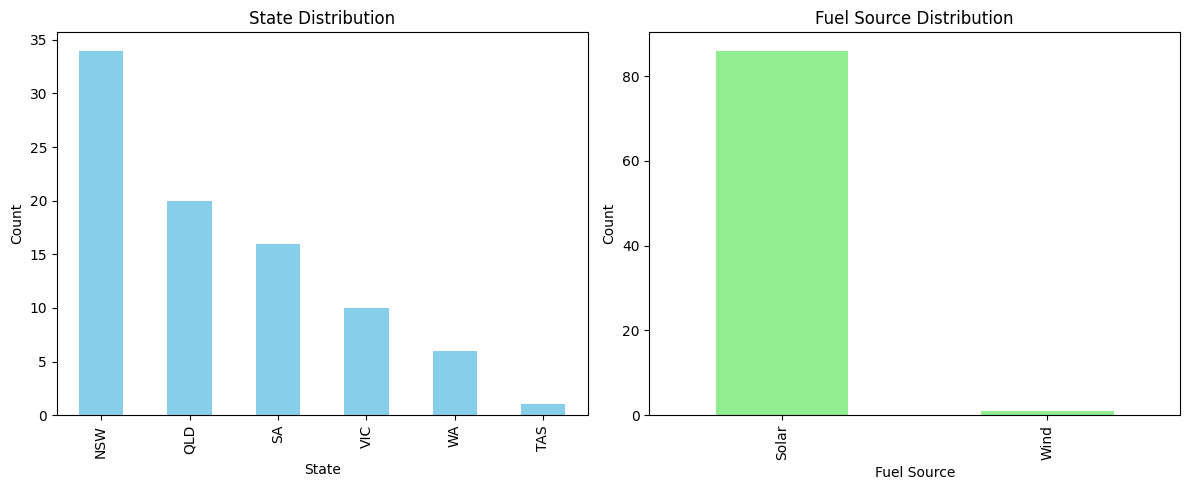

In [96]:
# data is good, ordinarily we would change last two columns to datetime but we are not interested in approval dates
# we mostly want location, fuel source and capacity

# let's start by renaming the columns to be more manageable
df1.columns = df1.columns.str.lower().str.replace(' ', '_') 

# standardise some of these column names
df1 = df1.rename(columns={
    'installed_capacity_mw': 'capacity_mw',
    'fuel_source_(s)':        'fuel_source',
    'accreditation_start_date': 'start_date',
    'approval_date':            'approval_date'
})

# let's see the spread of states and fuel sources side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# plot state distribution
df1['state'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue', title='State Distribution')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Count')

# plot fuel source distribution
df1['fuel_source'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen', title='Fuel Source Distribution')
axes[1].set_xlabel('Fuel Source')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [97]:
# let's now see what we can do with this data, can we visualise it on a neat little map ? 
import pgeocode
import folium
from folium import plugins

# get the coordinates for each state
nomi = pgeocode.Nominatim('au')
coords = nomi.query_postal_code(df1['postcode'].astype(str))
df1['lat'] = coords.latitude
df1['lon'] = coords.longitude

In [98]:
# Check how many power stations have missing coordinates
total_stations = len(df1)
stations_with_coords = df1.dropna(subset=['lat', 'lon']).shape[0]
missing_coords = total_stations - stations_with_coords

print(f"Total power stations: {total_stations}")
print(f"Stations with coordinates: {stations_with_coords}")
print(f"Missing coordinates: {missing_coords} ({missing_coords/total_stations:.1%})")

# Create a clean dataframe with only stations that have coordinates
df_map = df1.dropna(subset=['lat', 'lon']).copy()

Total power stations: 87
Stations with coordinates: 0
Missing coordinates: 87 (100.0%)


In [99]:
# Create a proper folium map centered on Australia
m = folium.Map(location=[-25, 134], zoom_start=4, tiles='CartoDB positron')

# Add a title to the map
title_html = '''
<h3 align="center" style="font-size:16px"><b>Australian Power Stations by Fuel Type and Capacity</b></h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

## Interactive Power Station Map of Australia

Let's create an interactive map that shows the distribution of power stations across Australia. We'll color-code each station by fuel source and size the markers proportionally to their installed capacity (MW). 

This visualization will help us understand:
1. The geographic distribution of energy generation
2. The relative scale of different power stations
3. The clustering of particular fuel sources in specific regions

In [93]:
# Create a color mapping for different fuel sources
fuel_colors = {
    'Solar': 'orange',
    'Wind': 'lightblue',
    'Hydro': 'blue',
    'Coal': 'black',
    'Gas': 'gray',
    'Biomass': 'green',
    'Battery': 'purple'
}

# Default color for any other fuel types
default_color = 'red'

# Get the column name for installed capacity
capacity_col = 'capacity_mw' if 'capacity_mw' in df1.columns else 'installed_capacity_(mw)'

# Use the filtered dataframe with valid coordinates
for _, row in df_map.iterrows():
    # Get the capacity
    capacity = row[capacity_col]
    
    # Scale the radius based on capacity (but keep it visible)
    radius = max(np.sqrt(capacity) * 0.5, 2)
    
    # Get color based on fuel source
    fuel = row['fuel_source']
    color = fuel_colors.get(fuel, default_color)
    
    # Create a detailed popup
    popup_text = f"""<b>{row['power_station_name']}</b><br>
                Capacity: {capacity} MW<br>
                Fuel: {fuel}<br>
                State: {row['state']}"""
    
    # Add the marker to the map
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=radius,
        color='black',
        weight=0.5,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=200)
    ).add_to(m)

## Clustered Map of Power Stations

To better visualize areas with many power stations close together, let's create a map with clustering. This will help us identify energy generation hotspots across Australia.

## Postcode Areas Colored by Dominant Energy Type

To better understand the geographic distribution of different energy types across Australia, let's create a visualization that colors postcode areas based on their dominant fuel source. This will give us a clearer picture of which regions are focused on which types of power generation.

In [100]:
import folium.plugins

# First, let's print the unique fuel types and check our color mapping
print("Unique fuel types in dataset:", df1['fuel_source'].unique())
print("\nColor mapping:")
for fuel, color in fuel_colors.items():
    print(f"- {fuel}: {color}")

# Determine the dominant fuel type by postcode based on capacity
postcode_fuel = df1.groupby(['postcode', 'fuel_source'])[capacity_col].sum().reset_index()

# Get the dominant fuel type (highest capacity) for each postcode
dominant_fuel = postcode_fuel.loc[postcode_fuel.groupby('postcode')[capacity_col].idxmax()]
dominant_fuel = dominant_fuel[['postcode', 'fuel_source', capacity_col]]
print(f"\nFound dominant fuel types for {len(dominant_fuel)} postcodes")

# Print some examples of dominant fuel types for verification
print("\nSample of dominant fuel types by postcode:")
print(dominant_fuel.sample(5))

# Aggregate key information for our postcode visualization
postcode_info = dominant_fuel.copy()  # Use the correct dominant fuel type

# Add coordinates by merging with our location data
postcode_coords = df_map.groupby('postcode').agg({
    'lat': 'mean',  # Average latitude
    'lon': 'mean',  # Average longitude
}).reset_index()

postcode_info = postcode_info.merge(postcode_coords, on='postcode', how='inner')
print(f"\nPostcodes with both dominant fuel and coordinates: {len(postcode_info)}")

# Create a map for postcode visualization
postcode_map = folium.Map(location=[-25, 134], zoom_start=4, tiles='CartoDB positron')

# Add title
postcode_map.get_root().html.add_child(folium.Element(
    '<h3 align="center" style="font-size:16px"><b>Australian Power Generation by Postcode Area</b></h3>'
))

# Create circle areas representing postcodes, with clear coloring
for _, row in postcode_info.iterrows():
    # Get color for this postcode's dominant fuel source
    fuel = row['fuel_source']
    color = fuel_colors.get(fuel, default_color)
    
    # Scale the circle size based on capacity
    radius = max(np.sqrt(row[capacity_col]) * 100, 1000)  # in meters
    
    # Create a detailed popup
    popup_text = f"""<b>Postcode: {row['postcode']}</b><br>
                <b>Dominant Energy: {fuel}</b><br>
                Total Capacity: {row[capacity_col]:.1f} MW"""
    
    # Add circle to represent postcode area with increased opacity
    folium.Circle(
        location=[row['lat'], row['lon']],
        radius=radius,  # meters
        color='black',
        weight=1,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,  # Increased opacity for better visibility
        popup=folium.Popup(popup_text, max_width=200)
    ).add_to(postcode_map)
    
    # Also add a small marker at the center for easier identification
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=2,
        color='black',
        weight=1,
        fill=True,
        fill_color=color,
        fill_opacity=1.0
    ).add_to(postcode_map)

# Add a legend to the map
legend_html = '''
<div style="position: fixed; 
    bottom: 50px; right: 50px; width: 180px; height: auto; 
    border:2px solid grey; z-index:9999; font-size:12px;
    background-color: white; padding: 10px;
    overflow: auto;">
    <p style="margin-top: 0; margin-bottom: 5px;"><b>Dominant Fuel Source</b></p>
'''

# Add each fuel type to the legend
for fuel, color in fuel_colors.items():
    legend_html += f'''
    <p style="margin-top: 0; margin-bottom: 5px;">
    <i class="fa fa-circle" style="color:{color};"></i> {fuel}</p>
    '''
    
legend_html += '''
</div>
'''
postcode_map.get_root().html.add_child(folium.Element(legend_html))

# Display the map
postcode_map

Unique fuel types in dataset: ['Solar' 'Wind']

Color mapping:
- Solar: orange
- Wind: lightblue
- Hydro: blue
- Coal: black
- Gas: gray
- Biomass: green
- Battery: purple

Found dominant fuel types for 75 postcodes

Sample of dominant fuel types by postcode:
    postcode fuel_source  installed_capacity_(mw)
17      2450       Solar                    1.323
20      2567       Solar                    0.220
70      6169       Solar                    0.574
29      3008       Solar                    0.119
58      5095       Solar                    0.250

Postcodes with both dominant fuel and coordinates: 0


In [85]:
# let's try another way
import geopandas as gpd

state_cap = df1.groupby('state')['installed_capacity_(mw)'].sum().reset_index()

# load the shapefile for Australian states
gstates = gpd.read_file('STE_2021_AUST_GDA2020.shp')

print(gstates.columns)
print(state_cap)

Index(['STE_CODE21', 'STE_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'AUS_CODE21',
       'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21', 'geometry'],
      dtype='object')
  state  installed_capacity_(mw)
0   NSW                   24.943
1   QLD                   10.751
2    SA                  203.465
3   TAS                    0.293
4   VIC                   39.774
5    WA                   19.707


In [86]:
# 2. Map codes → full state names
abbr_to_full = {
    'NSW': 'New South Wales',
    'VIC': 'Victoria',
    'QLD': 'Queensland',
    'SA':  'South Australia',
    'WA':  'Western Australia',
    'TAS': 'Tasmania',
    'NT':  'Northern Territory',
    'ACT': 'Australian Capital Territory'
}

state_cap['state_full'] = state_cap['state'].map(abbr_to_full)


In [87]:
gstates = gstates.merge(
    state_cap,
    left_on  = 'STE_NAME21',    # the shapefile’s full-name column
    right_on = 'state_full',    # your new full-name column
    how='left'
)


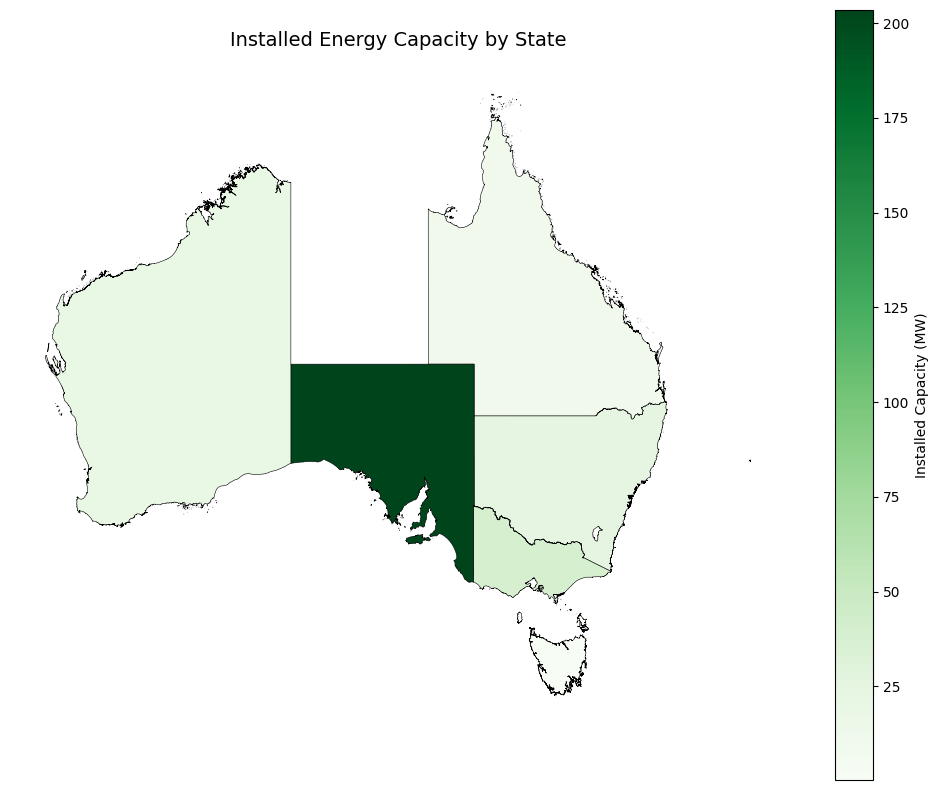

In [88]:
# 5. Plot the choropleth
fig, ax = plt.subplots(figsize=(10,8))
gstates.to_crs(epsg=3857).plot(
    column       = 'installed_capacity_(mw)',
    cmap         = 'Greens',
    edgecolor    = 'black',
    linewidth    = 0.4,
    legend       = True,
    legend_kwds  = {'label': 'Installed Capacity (MW)'},
    ax           = ax
)
ax.set_title("Installed Energy Capacity by State", pad=12, fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Analysis of Power Generation by Fuel Type and State

Now that we've visualized the geographic distribution of power stations, let's analyze the installed capacity by fuel type and state. This will give us a more quantitative understanding of Australia's energy mix.

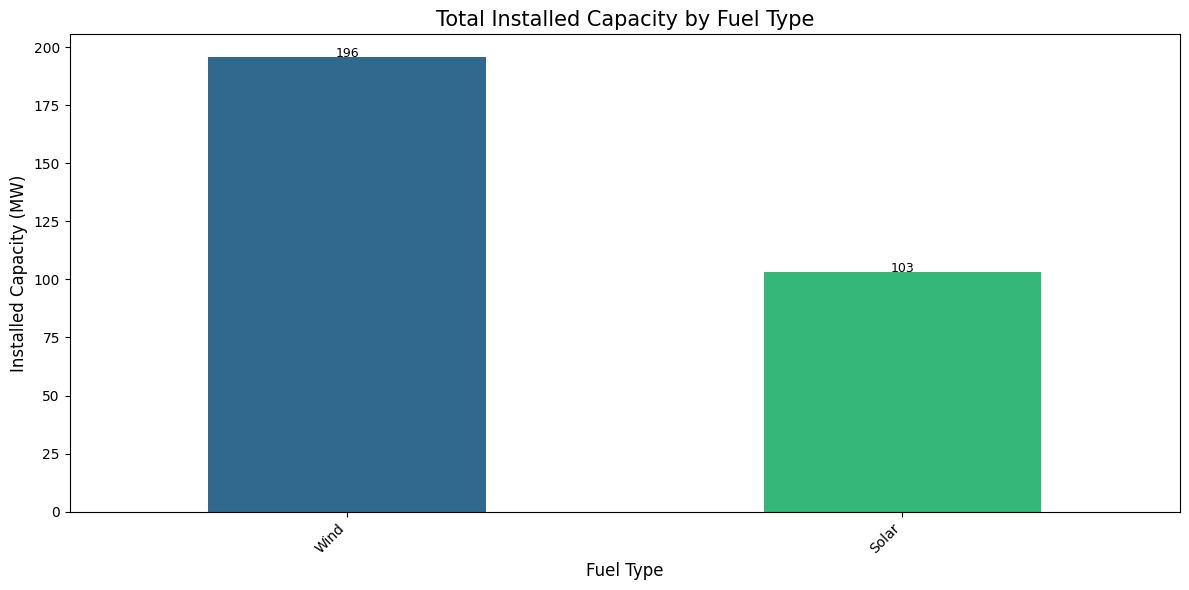

In [89]:
# Get the column name for installed capacity
capacity_col = 'capacity_mw' if 'capacity_mw' in df1.columns else 'installed_capacity_(mw)'

# Calculate total capacity by fuel type
fuel_capacity = df1.groupby('fuel_source')[capacity_col].sum().sort_values(ascending=False)

# Create a colorful bar chart
plt.figure(figsize=(12, 6))
ax = fuel_capacity.plot(kind='bar', color=sns.color_palette("viridis", len(fuel_capacity)))
plt.title('Total Installed Capacity by Fuel Type', fontsize=15)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Installed Capacity (MW)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add capacity values above bars
for i, v in enumerate(fuel_capacity):
    ax.text(i, v + 0.1, f'{v:,.0f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

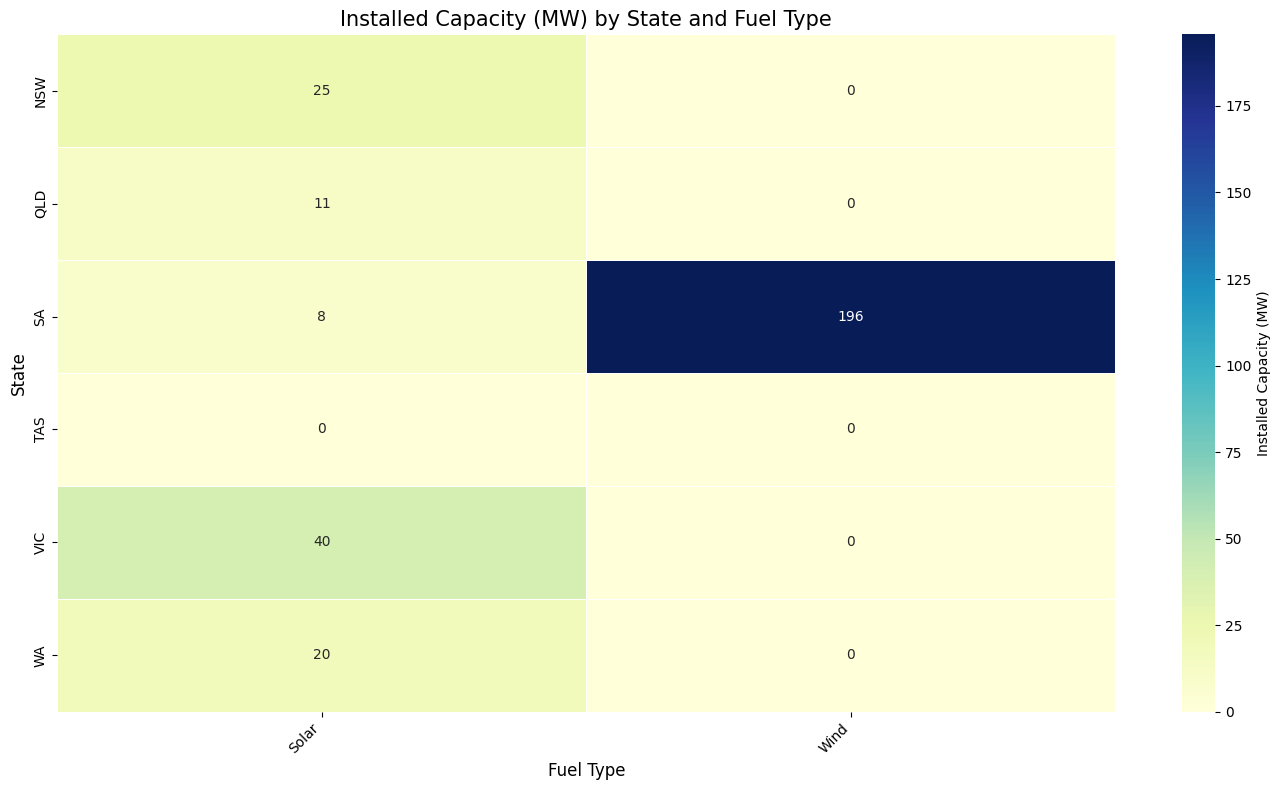

In [90]:
# Create a pivot table of capacity by state and fuel type
capacity_pivot = df1.pivot_table(
    index='state',
    columns='fuel_source', 
    values=capacity_col, 
    aggfunc='sum', 
    fill_value=0
)

# Create a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    capacity_pivot, 
    annot=True, 
    fmt='.0f', 
    cmap='YlGnBu', 
    linewidths=0.5, 
    cbar_kws={'label': 'Installed Capacity (MW)'}
)
plt.title('Installed Capacity (MW) by State and Fuel Type', fontsize=15)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

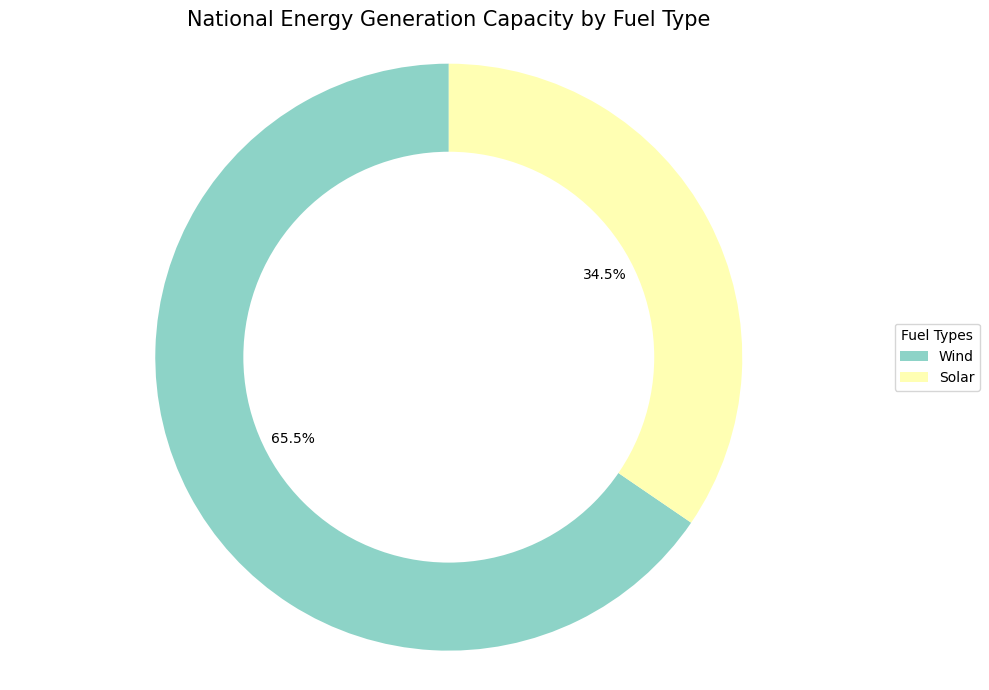

In [91]:
# Create pie charts for national and state-level fuel mix

# National fuel mix pie chart
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(
    fuel_capacity,
    autopct='%1.1f%%',
    textprops={'fontsize': 10},
    startangle=90,
    colors=sns.color_palette("Set3", len(fuel_capacity))
)

# Add a circle at the center to make it look like a donut chart
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.title('National Energy Generation Capacity by Fuel Type', fontsize=15)

# Add a legend
plt.legend(
    wedges, 
    fuel_capacity.index,
    title="Fuel Types",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.tight_layout()
plt.show()

## Key Insights from the Analysis

From our exploration of Australia's power generation landscape, we can observe several important patterns:

1. **Geographic Distribution**: Power stations are not evenly distributed across Australia, with clusters in certain areas, particularly along the east coast.

2. **Fuel Type Mix**: The visualizations reveal Australia's energy mix, showing the balance between traditional fossil fuels and renewable sources.

3. **State Differences**: There are significant variations between states in terms of both total capacity and fuel source preferences.

4. **Renewable Penetration**: The maps and charts illustrate the extent to which renewable energy has penetrated different regions of Australia.

These findings provide a foundation for further analysis in the upcoming parts of this series, where we might explore energy production patterns, market dynamics, and future trends in the Australian energy landscape.